<a href="https://colab.research.google.com/github/Nick7900/permutation_test/blob/main/a_between_subject_testing_old.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Perform permutation - Between-Subject Testing Tutorial**
In this tutorial, we will learn how to use the ```between_subject_test``` function to perform permutation testing on between-subject data. The ```between_subject_test``` function is useful when you want to compare data between different subjects, groups or continuous traits like intelligence. It is commonly used in experimental or observational studies to assess differences in data across different individuals.

When analyzing between-subject data, it is essential to consider and address potential confounding variables that could influence the results. Confounding variables are external factors that are associated with both the independent variable and the dependent variable.

The ```between_subject_test``` makes it possible to mitigate the influence of confounding variables by regressing them out from data before performing the between-subject test.

Here are a few examples where ```between_subject_test``` testing can be useful:

- **Clinical Trials**: In clinical trials, researchers often compare the effectiveness of different treatments or interventions across a group of patients. ```between_subject_test``` can be used to assess whether there are significant differences between treatment groups.

- **Neuroimaging Studies**: In neuroimaging studies, researchers may compare brain activation patterns in relation to continuous traits like reaction time to see how variations in reaction time are associated with specific neural networks or brain regions.


## **Permutation testing**
Permutation testing is a resampling technique that involves random permutation of the observed data and comparing it to the observed effect to by generating a null distribution under the null hypothesis.

The null hypothesis states that there is no difference or association between variables of interest.

Under the null model, we can determine the p-value and assess the significance of the effect.

Permutation testing (non-parametric) is particularly useful when the underlying data distribution is unknown or violates certain assumptions required by parametric tests. It provides a flexible and robust alternative for hypothesis testing, especially in cases where parametric assumptions cannot be met.

## **Importance of Exchangeable Data in Permutation Testing**
Permutation testing assumes that the data can be permuted without affecting the underlying relationship between the variables. When the data is exchangeable, the order of subjects does not matter, and we can permute the subjects randomly without altering the underlying relationship between brain activity and the dependent variable. This property allows us to generate an accurate null distribution for hypothesis testing.

However, in some cases, the data may not be exchangeable, where the order of datapoint (e.g. trials) are dependent on the previous and future datapoint.
We will cover scenarios using the ```between_subject_test``` function where the data is exchangeable (i.e., the order of data does not matter) and where it is not.


**We will go though the following steps in this Notebook:**

1. Setup Google Colab
2. Downloading data for analysis
3. Example 1 - Exchangeability = True
  - Data preparation
  - Permutation testing - between subject testing
  - Example of usage - Regression
  - P-value correction
  - Visualize results
4. Example 2 - Exchangeability = False

## **1: Setup Google Colab**
This script was written using **Google Colab** and you need to install different packages to run this code and import libraries to load the data that we prepared in the Notebook ```1_preprocessing_data_selection```.


To use the helper function ```my_functions``` you need to install the library **statsmodels**.
```
pip install statsmodels
```
To visualize a process bar while processing the data we need to install the library ```tqdm```
```
pip install tqdm
```

When using **Google Colab** we need to import the following libraries, so we can load the data of interest

```
!pip install requests
!pip install gdown
```


To train the HMM, install the GLHMM toolkit in your Python environment.
```
pip install --user git+https://github.com/vidaurre/glhmm
```

In **Google Colab** we will clone the toolbox


### Install packages

In [ ]:
# Using -q gwpy to hide output in Google Colab
!pip install statsmodels -q gwpy
!pip install tqdm -q gwpy
!pip install requests -q gwpy
!pip install gdown -q gwpy
# Clone the GLHMM into Google Colab
!git clone https://github.com/vidaurre/glhmm
%cd glhmm

fatal: destination path 'glhmm' already exists and is not an empty directory.
/content/glhmm


### Import libraries
Now, we can begin to import the necessary libraries for our analysis. We'll be using ```os``` and ```numpy```, for loading the data and for data manipulation.

In [ ]:
import os
import numpy as np
import requests
import gdown
from glhmm import glhmm

### Load Helper function
We will use ```my_functions.py``` to visualize the different plots of our results

----------------------------
**Note these functions will be remove for loading if they are part of the GLHMM toolbox => no need to run this code**

In [ ]:
# Import helper function
# Move back to main folder
%cd ..
# Get the raw github file
url = 'https://raw.githubusercontent.com/Nick7900/permutation_test/main/helper_functions/my_functions.py'
r = requests.get(url)
# Save the function to the directory
with open("my_functions.py","w") as f:
  f.write(r.text)

/content


### Load Permutationt testing functions
We will use ```permutation_test.py``` to perform the permutation testing

In [ ]:
# Import helper function
# Get the raw github file
url = 'https://raw.githubusercontent.com/Nick7900/permutation_test/main/helper_functions/permutation_test.py'
r = requests.get(url)
# Save the function to the directory
with open("permutation_test.py","w") as f:
  f.write(r.text)

## **2: Downloading prepared data for analysis**

Initially, we have to load data files into our Python environment. We will handle three data files named ```data_behavioral```, ```data_neuroimaing.npy``` and ```gamma.npy```.

These files were generated in the two notebooks named ```1_preprocessing_data_selection``` and ```2_preprocessing_data_selection```. However, for this tutorial's convenience, we will directly download them since they have already been prepared.

In [ ]:
# Define the folder and file names
folder_name = ""
# data_behavioral file
url = "https://drive.google.com/uc?id=11SiUao3gYVApQCe6XzOT4L8zcZLQetat&export=download"
gdown.download(url, quiet=True)
# data_neuroimaging file
url = "https://drive.google.com/uc?id=1bPhw4GOoLDqkMWvVbkRAIh_XYG6L0JQZ&export=download"
gdown.download(url, quiet=True)
# data_gamma_file
url = "https://drive.google.com/uc?id=1uaKW2n2sCP8RPLTBlVPoC6n-FMarvzq6&export=download"
gdown.download(url, quiet=True)

'gamma.npy'

Save variables

In [ ]:
data_behavioral_file = 'data_behavioral.npy'
data_neuroimaging_file = 'data_neuroimaging.npy'
data_gamma_file = 'gamma.npy'

# Load behavioral data
file_path = os.path.join(folder_name, data_behavioral_file)
data_behavioral = np.load(file_path)

# Load measurement data
file_path = os.path.join(folder_name, data_neuroimaging_file)
data_neuroimaging = np.load(file_path)

# Load gamma data
file_path = os.path.join(folder_name, data_gamma_file)
data_gamma = np.load(file_path)


### Explore data

Now we can look at the data structure.

What we can see here is that ```data_measurement =[1003, 1200, 50]```. \
What the data really contains are 1003 subject and each subject has been measured of a period of time(T) for 1200 timestamps and 50 parcellations over the brain.

For the corresponding 1003 subjects, we got ```data_behavioral =[1003,2]```, which are **behavioral measurement** of each subjects *sex* and *age*.

When we look at ```data_gamma =[1203600, 8]```. The gamma measurement are concatenated for every timepoint for each subject 1203600 (1003 by 1200). We got 8 columns and each represents the 8 different states at each timepoint per subject.


In [ ]:
print(f"Data dimension of data_neuroimaging: {data_neuroimaging.shape}")
print(f"Data dimension of data_behavioral: {data_behavioral.shape}")
print(f"Data dimension of data_gamma: {data_gamma.shape}")

Data dimension of data_neuroimaging: (1003, 1200, 50)
Data dimension of data_behavioral: (1003, 2)
Data dimension of data_gamma: (1203600, 8)


## **3: Example 1 - Exchangeability = True**
**Fractional occupancy (FO)** within Hidden Markov Models (**HMMs**) measures the duration spent in each state, allowing time-series data like **Gamma** data with temporal dependencies, becoming exchangeable. Time-series data often have correlated observations at consecutive timepoints, and the order of data points can significantly influence statistical analyses. **FO** condenses the states of the entire time series and enables statistical assessments even in the presence of temporal dependencies.


### **Data preparation**

#### **Calculate indices**
Before we can calculate **FO** of the **gamma's** we need to specify the indices in the concatenated timeseries corresponding to the beginning and end of individual subjects/sessions in the shape ```[n_subjects, 2]```.

In [ ]:
from my_functions import get_timestamp_indices
#Generate indices of the timestamps for each subject in the data.
n_s, n_timepoints, n_features =data_neuroimaging.shape # [60, 300, 50]
idx_time =get_timestamp_indices(n_timepoints,n_s)
# Visualize the first 10 timepoints
idx_time[:10]

array([[    0,  1200],
       [ 1200,  2400],
       [ 2400,  3600],
       [ 3600,  4800],
       [ 4800,  6000],
       [ 6000,  7200],
       [ 7200,  8400],
       [ 8400,  9600],
       [ 9600, 10800],
       [10800, 12000]])

#### **Calculate Fractional Occupancy (FO)**
Now that we got the indices we can calculate FO

In [ ]:
# Calculate FO
FO =glhmm.utils.get_FO(data_gamma,idx_time)

Now that we have the data prepared for the analysis we will show how to perform between-subject testing using the ```between_subject_test``` function. We will use an example dataset consisting of **fractional occupancy measurements** and the corresponding **behavioral measurements**. Like previous stated, the behavioral measurements include information about the subjects' *sex* and *age*.

To make the jupyter notebook consistent with the functions input we will define **fractional occupancy measurements** to be the input data (```X_data```) and the **behavioral measurements** to be the dependent matrix (```y_data```)

In [ ]:
X_data = FO.copy()
y_data = data_behavioral.copy()
print('X_data shape:', X_data.shape)
print('y_data shape:', y_data.shape)

X_data shape: (1003, 8)
y_data shape: (1003, 2)


The ```X_data``` array has a shape of (1003, 8), indicating 1003 subjects with their corresponding 8 fractional occupancy measurements. The ```y_data``` array has a shape of (1003, 2), indicating 1003 subjects and their 2 behavioral measurements (sex and age).

### **Permutation testing - between subject testing**
The ```between_subject_test``` function is designed to perform permutation tests on between subject. It includes multiple functions to handle the permutation generation, and statistical calculations. The main purpose of this function is to determine the statistical significance of observed patterns in the data by generating random permutations and comparing the results.


In [ ]:
# import between_subject_test
from permutation_test import between_subject_test # This function should just be in the GLHMM package

#### **Parameters**
The ```between_subject_test``` function accepts the following parameters:

* X_data (numpy.ndarray):
                                Input data array of shape that can be either a 2D array or a 3D array.
                                For 2D array, it got a shape of (n_ST, n_features), where n_ST represent
                                the number of subjects or trials, and each column represents a feature (e.g., brain
                                region or channel)
                                For a 3D array,it got a shape (n_timepoints, n_ST, n_features), where the first dimension
                                represents timepoints, the second dimension represents the number of subjects or trials,
                                and the third dimension represents features.
                                In the latter case, permutation testing is performed per timepoint for each subject.  
* y_data (numpy.ndarray):
                                The dependent-variable can be either a 2D array or a 3D array.
                                For 2D array, it got a shape of (n_ST, n_predictors), where n_ST represent
                                the number of subjects or trials, and each column of n_predictors represents a
                                dependent variable.
                                For a 3D array,it got a shape (n_timepoints, n_ST, n_predictors), where the first dimension
                                represents timepoints, the second dimension represents the number of subjects or trials,
                                and the third dimension that is n_predictors represents a dependent variable

* idx_data (ndarray):     
                                It can take index data of shape (n_trials, 2) indicating start and end indices of trials or
                                an 1D array of shape (n_ST,) where the indices are defined for each subject/trial .
                                Required if exchangeable=True. Defaults to None.     
* method (str, optional):       
                                The statistical method to be used for the permutation test. Valid options are
                                "regression", "correlation", or "correlation_com". (default: "regression").
                                "regression" returns the statistical significance of the beta coefficient.
                                "correlation" returns the statistical significance of Pearson’s correlation coefficient.
                                "correlation_com" returns the combined statistical significance of Pearson’s correlation
                                coefficient and 2-tailed p-value

* Nperm (int):  
                                Number of permutations to perform (default: 1000).
* confounds (numpy.ndarray or None, optional):
                                The confounding variables to be regressed out from the input data (X_data).
                                If provided, the regression analysis is performed to remove the confounding effects.
                                (default: None):                               
* exchangeable (bool, optional):
                                If True, the function performs exchangeable permutation between subjects based
                                on the provided `idx_data`. (default: False).
                                       
* test_statistic_option (bool, optional):
                                If True, the function will return the test statistic for each permutation.
                                (default: False)

### Returns
The ```between_subject_test``` function returns different things depending on the settings of `test_statistic_option` and `method`, it can return the p-values, correlation coefficients, test statistics.'


* pval (numpy array):
                                p-values for the test (n_timepoints, n_features) if method=="Regression", else
                                (n_timepoints, n_features, n_predictors).
* corr_coef (numpy array):
                                Correlation Coefficients for the test n_timepoints, n_features, n_predictors) if'
                                method=="correlation or "correlation_com", else None.
* test_statistic_list (numpy array):
                                Test statistic values (n_timepoints, Nperm,
                                n_features) if test_statistic_option is True, else None.

* pval_list (numpy array):
                                P-values for each time point (n_timepoints, Nperm, n_features)
                                if test_statistic_option is True and method is "correlation_com", else None.


### **Example of usage - Regression**
The ```between_subject_test``` function with the "regression" permutation testing method assesses the statistical significance of the relationship between brain activity (Fractional Occupancy output from an HMM) and dependent variables (behavioral data) for each subject. It uses regression to model and quantify this relationship, examining how changes in brain activity relate to variations in behavioral variables of 'age' and 'sex'). The function tests whether the observed brain-behavior relationship is significant. Also, it is possible to take  potential confounding variables into consideration and regress these out through permutation testing.

----------------------
Question: Is it okay to do the regression while including both 'age' and 'sex' or should it be done independently?


In [ ]:
# Set the parameters for between-subject testing
method = "regression"
Nperm = 10000
test_statistic_option=True
exchangeable = True
confounds = None


# Perform between-subject testing
pval, test_statistic_list  =between_subject_test(X_data, y_data, method=method,Nperm=Nperm,confounds=confounds,test_statistic_option=test_statistic_option, exchangeable=exchangeable)
pval

performing permutation testing for whole data


100%|██████████| 10000/10000 [00:01<00:00, 9061.54it/s]


array([[6.22437756e-01, 2.59974003e-03, 6.60933907e-02, 7.81921808e-02,
        2.79972003e-03, 2.80071993e-01, 9.99900010e-05, 7.49925007e-02]])

### **P-value correction**
After calculating the p-value with the ```between_subject_test``` function and performing a permutation test using regression, we apply correction for multiple comparisons along the first dimension of the input p-values matrix. The correction is independently applied to each row of the matrix.

The function ```pval_test``` is designed to perform p-value correction to address multiple comparisons. It expects the pval input as a matrix or array of p-values, with each row representing p-values associated with different hypotheses or tests.

The correction for multiple comparisons utilizes the ```statsmodels.stats.multitest.multipletests``` function from the statsmodels library. This function employs various methods to control the false discovery rate (FDR) or family-wise error rate when dealing with multiple hypotheses/tests.

By default, the function applies FDR correction using the **Benjamini/Hochberg method**.

In [ ]:
from my_functions import pval_test, plot_heatmap, plot_scatter_with_labels,plot_histograms
alpha = 0.05
p_values_corrected,rejected_corrected  =pval_test(pval, alpha =alpha)
# Identify significant results after correction
significant_indices_corrected = np.where(p_values_corrected < alpha)

# Print the significant results
print("Corrected P-value:", p_values_corrected)
print("Significant Time Points (Thresholding + Correction):", significant_indices_corrected)

Corrected P-value: [[0.62243776 0.00746592 0.10425624 0.10425624 0.00746592 0.32008228
  0.00079992 0.10425624]]
Significant Time Points (Thresholding + Correction): (array([0, 0, 0]), array([1, 4, 6]))


### **Visualize results**
 Visualize the results by creating some plotting functions. Here's an example of how to plot the p-values

 **Vizualize p-values using Heatmaps**

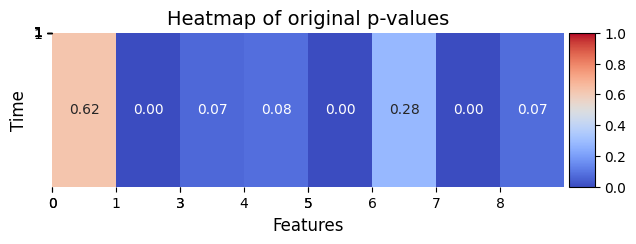

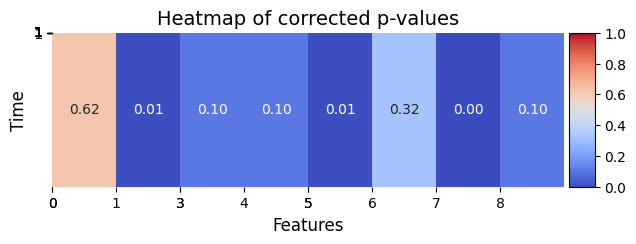

In [ ]:
# Plot p-values
plot_heatmap(pval,method, title_text ="Heatmap of original p-values",figsize=(7, 2), )

plot_heatmap(p_values_corrected,method, title_text ="Heatmap of corrected p-values",figsize=(7, 2))

**Vizualize p-values using scatter plots**

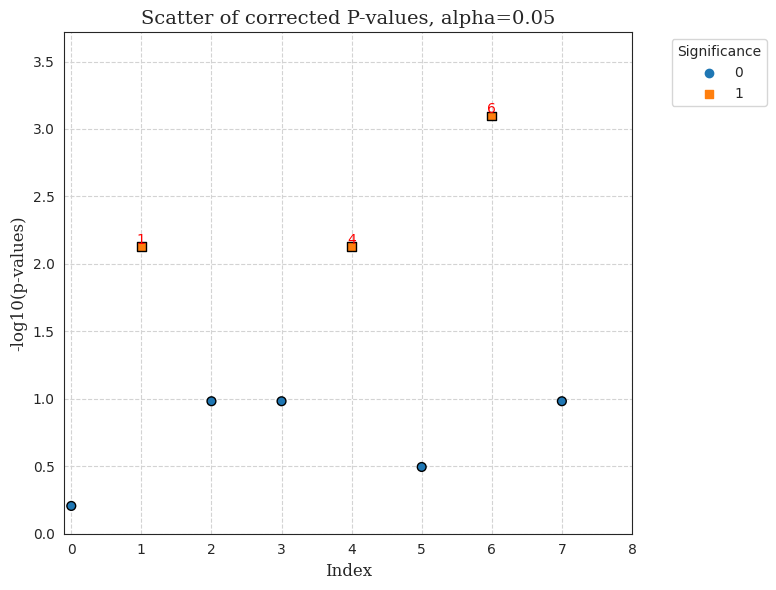

In [ ]:
# Reduce the dimensionality of the first dimension of corrected pvalues
title_text = f"Scatter of corrected P-values, alpha={alpha}"
plot_scatter_with_labels(np.squeeze(p_values_corrected), alpha=0.05,xlim_start=-0.1,ylim_start=0, title_text=title_text)

**Plot the test staticstic of significant values**

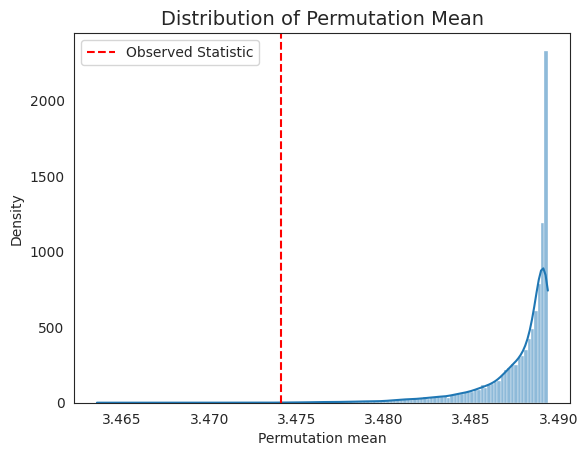

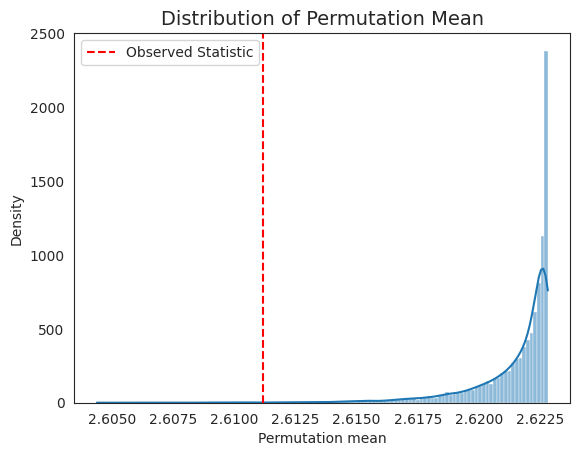

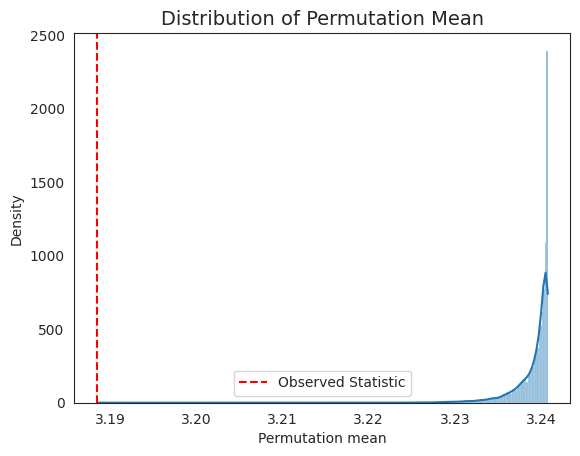

In [ ]:
# Plot test statistics for uncorrected pvals
significant_timestamp_position, significant_indices = np.where(p_values_corrected < alpha)
for i in significant_indices:
    plot_histograms(np.squeeze(test_statistic_list)[:,i])

## **4: Example 2 - Exchangeability = False**
In neuroscience studies, the standard assumption is that trials are exchangeable, meaning the sequence of data points (trials) doesn't influence the underlying statistical characteristics. However, this assumption may not always hold true in certain neuroscience studies, as some experimental designs or data collection processes can introduce biases or dependencies among trials, potentially affecting the outcomes based on trial order.

To illustrate this concept, let's consider the previous dataset was measured in 1200 trials instead of being represented as a time series dataset of 1200 time points. In this simplified scenario, each subject's measurements are treated as individual trials.

For example, when analyzing trial number 0, the permutation testing is exclusively done for trial number 0 across all subjects in the dataset. This ensures that the permutation analysis is tailored to each subject's specific trial configuration, allowing a fair comparison of brain activity and dependent variables between subjects. By employing this approach, the code accounts for potential violations of exchangeability assumptions, leading to more reliable statistical assessments in such scenarios.

### Criteria to run the code
To run the function ```between_subject_test``` when exchangeability is not guaranteed, it is required that each subject/session has an equal number of trials. Otherwise, performing the permutation equally becomes infeasible.
Here's the step-by-step process to achieve this:

- Concatenate Data (```X_data```): Combine the neuroimaging data from all subjects to create the matrix ```X_data```. This matrix represents brain activity data, where each row corresponds to a time point or trial, and each column represents a different brain region or feature.

- Create Dependent Matrix (```y_data```): Prepare the behavioral data, including variables of interest (e.g., "sex" and "age"), in a dependent matrix format. Align the behavioral data with the corresponding measurements in ```X_data``` by repeating the values for each subject/session. This results in the matrix ```y_data```, where each row corresponds to a subject/session, and the columns contain the behavioral variables.

- Assign Index to Each Subject/Session (```idx_data```): Create an index array ```idx_data``` to associate each row of the concatenated data (```X_data```) with the corresponding subject/session. The index array ensures that the permutation testing is conducted within the context of each subject/session, preserving the exchangeability assumption.

In [ ]:
# 1. Concatenate the data for each subject/session
X_data = np.concatenate([data_neuroimaging[i] for i in range(data_neuroimaging.shape[0])], axis=0)
# 2. Align behaviral data with corresponding X_data
y_data = np.repeat(data_behavioral,data_neuroimaging.shape[1], axis=0)
# Indices for concatenating the data for each subject/session
idx_data = np.repeat(range(0,data_neuroimaging.shape[0]), data_neuroimaging.shape[1])

In [ ]:
print(f"Data dimension of X_data: {X_data.shape}")
print(f"Data dimension of y_data: {y_data.shape}")
print(f"Data dimension of data_gamma: {idx_data.shape}")

Data dimension of X_data: (1203600, 50)
Data dimension of y_data: (1203600, 2)
Data dimension of data_gamma: (1203600,)


### **Example of usage - Correlation**
The function ```between_subject_test``` with the ```correlation_com``` permutation testing method aims to determine the statistical significance of correlations between brain activity (```X_data```) and behavioral variables (```y_data```), specifically "sex" and "age." In this context, ```correlation_com``` stands for "correlation combined" and returns the both the statistical significance of Pearson’s correlation coefficient and 2-tailed p-value

In the provided dataset, ```X_data``` represents concatenated brain activity data for multiple trials and brain regions. Each row corresponds to a trial number, and each column represents different brain parcellations.

```y_data``` contains behavioral information for each subject, including "sex" and "age." Each row corresponds to a subject, and the columns contain the subject's "sex" and "age" values.





In [ ]:
# Set the parameters for between-subject testing
method = "correlation_com" # returns the combined statistical significance of Pearson’s correlation coefficient and 2-tailed p-value
Nperm = 1000
test_statistic_option=True
exchangeable =False
# Perform between-subject testing
pval, corr_coef, test_statistic_list, pval_list  =between_subject_test(X_data, y_data, idx_data, method, exchangeable=exchangeable,Nperm=Nperm, test_statistic_option=test_statistic_option)

performing permutation testing for whole data


  0%|          | 0/1000 [00:00<?, ?it/s]

Look at output shapes

In [ ]:
print(f"Data dimensiony of data_measurement: {pval.shape}")
print(f"Data dimension of data_behavioral: {corr_coef.shape}")

It should be noted that the dimensions of the variables ```pval``` and ```corr_pval``` in the code are ```[1, 50, 2]```. The design of the code assumes that the results correspond to each individual time point in a study.\
However, in this particular example, the data has been consolidated into a single two-dimensional matrix. Consequently, the first dimension or column of the matrix can be disregarded.

### **P-value correction**

In [ ]:
alpha = 0.05
p_values_corrected,rejected_corrected  =pval_test(pval, alpha =alpha)
# Identify significant results after correction
significant_indices_corrected = np.where(p_values_corrected < alpha)

# Print the significant results
print("Significant Time Points (Thresholding + Correction):", significant_indices_corrected)

### **Visualize results**
 Visualize the results by creating some plotting functions. Here's an example of how to plot the correlation coefficients and p-values.

In [ ]:
# Plot p-values
plot_heatmap(pval[0,:], method, normalize_vals=True, figsize=(12, 10), steps=11, annot=True)
plot_heatmap(p_values_corrected[0,:], method, normalize_vals=True, figsize=(12, 10), steps=11, title_text="Heatmap p-values corrected", annot=True)

Heat map for correlation

In [ ]:
plot_heatmap(corr_coef[0,:], method, normalize_vals=True, figsize=(12, 10), steps=11, annot=True, title_text="Heatmap of correlation coefficients")